<a href="https://colab.research.google.com/github/Vaibhavrathore1999/ML-building-blocks/blob/main/ViT_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import torch
import torch.nn as nn

In [4]:
class GELU(nn.Module):
  def __init__(self):
    super(GELU,self).__init__()
    pass
  def forward(self,x):
    return (0.5*x*(1+torch.tanh(torch.tensor(2/math.pi)**0.5)*(x+0.044715*torch.pow(x,3.0))))


## Convert Image into Patches

In [5]:
class PatchEmbeddings(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,emb_size):
    assert (img_size%patch_size==0), "image size must be divisible by patch size"
    super(PatchEmbeddings,self).__init__()
    self.img_size=img_size
    self.patch_size=patch_size
    self.n_patches=(img_size//patch_size)**2
    # Convert each patch into embedding
    self.proj=nn.Conv2d(in_channels,emb_size,kernel_size=(patch_size,patch_size),stride=patch_size)
  def forward(self,x):
    # Shape of x ---> (batch_size,num_channels,image_size,image_size). get converted to (batch_size,num_patches,emb_dim)
    x=self.proj(x)      # ----> (batch_size,emb_dim,img_size//patch_size,img_size//patch_size)
    x=x.flatten(2)      # ----> (batch_size,emb_dim,num_patches)
    x=x.transpose(1,2)  # ----> (batch_size,num_patches,emb_dim)
    return x

In [6]:
class PatchEmbeddings_v2(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,emb_size):
    assert (img_size%patch_size==0), "image size must be divisible by patch size"
    super(PatchEmbeddings,self).__init__()
    self.img_size=img_size
    self.patch_size=patch_size
    self.n_patches=(img_size//patch_size)**2
    self.linear=nn.Linear(in_channels*patch_size*patch_size,emb_size)
  def forward(self,x):
    # Shape of x ---> (batch_size,num_channels,image_size,image_size). get converted to (batch_size,num_patches,emb_dim)
    patches=x.unfold(2,self.patch_size.self.patch_size).unfold(3,self.patch_size,self.patch_size)
    patches=patches.contiguous().view(x.shape[0,self.n_patches,-1])
    return self.linear(patches)


## Add Learnable Positional Embeddings

In [7]:
class Embedding(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,emb_size,dropout):
    super(Embedding,self).__init__()
    self.patch_embeddings=PatchEmbeddings(img_size,patch_size,in_channels,emb_size)
    # Create a learnable [CLS] Token
    self.cls_token=nn.Parameter(torch.randn(1,1,emb_size))
    self.dropout=nn.Dropout(dropout)
    self.pos_embbedings=nn.Parameter(torch.randn(1,self.patch_embeddings.n_patches+1,emb_size))
  def forward(self,x):
    x=self.patch_embeddings(x)
    cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
    x=torch.cat((cls_tokens,x),dim=1)
    x=x+self.pos_embeddings
    x=self.dropout(x)

## Add Fixed sine and cosine pos embeddings

In [8]:
class Embedding_v2(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,emb_size,dropout):
    super(Embedding_v2,self).__init__()
    self.patch_embeddings=PatchEmbeddings(img_size,patch_size,in_channels,emb_size)
    # Create a learnable [CLS] Token
    self.cls_token=nn.Parameter(torch.randn(1,1,emb_size))
    self.dropout=nn.Dropout(dropout)
    self.pos_embeddings=self.get_sinusoidal_positional_embeddings(self.patch_embeddings.n_patches+1,emb_size)

  def get_sinusoidal_positional_embeddings(self, num_positions, emb_size):
    """
    Generate sinusoidal positional embeddings using both sine and cosine functions.
    """
    position = torch.arange(0, num_positions, dtype=torch.float).unsqueeze(1)  # (num_positions, 1)
    div_term = torch.exp(torch.arange(0, emb_size, 2).float() * -(math.log(10000.0) / emb_size))  # (emb_size / 2)

    # Apply sine to even indices (2i)
    pos_emb = torch.zeros(num_positions, emb_size)
    pos_emb[:, 0::2] = torch.sin(position * div_term)
    pos_emb[:, 1::2] = torch.cos(position * div_term)
    return pos_emb.unsqueeze(0)  # Shape: (1, num_positions, emb_size)

  def forward(self,x):
    x=self.patch_embeddings(x)
    cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
    x=torch.cat((cls_tokens,x),dim=1)           # ----> (batch_size,num_patches+1,emb_dim)
    x=x+self.pos_embeddings
    x=self.dropout(x)
    return x

In [9]:
class AttentionHead(nn.Module):
  def __init__(self,d_in,d_out,dropout):
    self.W_k=nn.Linear(d_in,d_out)        # Shape ---> (d_in,d_out)
    self.W_q=nn.Linear(d_in,d_out)
    self.W_v=nn.Linear(d_in,d_out)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    # Shape --> (batch, num_tokens, d_in)
    key=x@self.W_k          # Shape --> (batch, num_tokens, d_out)
    query=x@self.W_q        # Shape --> (batch, num_tokens, d_out)
    value=x@self.W_v        # Shape --> (batch, num_tokens, d_out)
    # Shape of attention matrix ----> (batch, num_tokens , num_tokens)
    attn_matrix= query@key.transpose(-2,-1)
    attn_matrix=attn_matrix/torch.sqrt(torch.tensor(key.shape[-1]))
    attn_matrix=torch.softmax(attn_matrix,dim=-1)
    attn_matrix=self.dropout(attn_matrix)
    context_vec=attn_matrix@value
    return context_vec            # # Shape --> (batch, num_tokens, d_out)


In [10]:
class MultiHeadWraper(nn.Module):
  def __init__(self,d_in,d_out,num_heads,dropout):
    super(MultiHeadWraper,self).__init__()
    self.num_heads=num_heads
    self.d_out=d_out
    self.d_in=d_in
    self.heads=nn.ModuleList([AttentionHead(d_in,d_out,dropout) for _ in range(num_heads)])

  def forward(self,x):
    # Shape --> (batch, num_tokens, d_in)
    x_=torch.cat([self.heads[i](x) for i in range(self.num_heads)],dim=-1)        # Shape ---> (batch,num_tokens,d_out*num_heads)
    return x_

In [11]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,num_heads,dropout):
    super(MultiHeadAttention,self).__init__()
    self.num_heads=num_heads
    self.d_out=d_out
    self.d_in=d_in
    assert (d_out%num_heads==0), "d_out should be divisible by num_haeds"
    self.W_k=nn.Linear(d_in,d_out)        # Shape ---> (d_in,d_out)
    # self.W_k=nn.Parameter(torch.randn(d_in,d_out))
    self.W_q=nn.Linear(d_in,d_out)
    self.W_v=nn.Linear(d_in,d_out)
    self.dim_head=d_out//num_heads
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    # Shape ---> (batch, num_tokens, d_in)
    keys=self.W_k(x)        # Shape ----> (batch,num_tokens,d_out)
    # keys=x@self.W_k
    queries=self.W_q(x)     # Shape ----> (batch,num_tokens,d_out)
    values=self.W_v(x)      # Shape ----> (batch,num_tokens,d_out)
    keys=keys.view(keys.shape[0],keys.shape[1],self.num_heads,self.dim_head)                   # Shape ----> (batch,num_tokens,num_heads,dim_head)
    queries=queries.view(queries.shape[0],queries.shape[1],self.num_heads,self.dim_head)       # Shape ----> (batch,num_tokens,num_heads,dim_head)
    values=values.view(values.shape[0],values.shape[1],self.num_heads,self.dim_head)           # Shape ----> (batch,num_tokens,num_heads,dim_head)
    keys=keys.transpose(1,2)                    # Shape ----> (batch,num_heads,num_tokens,dim_head)
    queries=queries.transpose(1,2)               # Shape ----> (batch,num_heads,num_tokens,dim_head)
    values=values.transpose(1,2)               # Shape ----> (batch,num_heads,num_tokens,dim_head)
    attn_matrix=queries@keys.transpose(-2,-1)     # Shape ---> (batch,num_heads,num_tokens,num_tokens)
    attn_matrix=attn_matrix/torch.sqrt(torch.tensor(keys.shape[-1]))
    attn_matrix=torch.softmax(attn_matrix,dim=-1)
    attn_matrix=self.dropout(attn_matrix)
    context_vec=attn_matrix@values        # Shape ---> (batch, num_heads, num_tokens,dim_head)
    context_vec=context_vec.transpose(1,2)      # Shape ---> (batch, num_tokens, num_heads,dim_head)
    context_vec=context_vec.contiguous().view(context_vec.shape[0],context_vec.shape[1],-1)         # Shape ---> (batch, num_tokens,d_out)
    return context_vec


In [12]:
class MLP(nn.Module):
  def __init__(self,d_in,hidden_size,dropout):
    super().__init__()
    self.fc1=nn.Linear(d_in,hidden_size)
    self.gelu=GELU()
    self.fc2=nn.Linear(hidden_size,d_in)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    x=self.fc1(x)
    x=self.gelu(x)
    x=self.fc2(x)
    x=self.dropout(x)
    return x

In [13]:
class LayerNorm(nn.Module):
  def __init__(self,d_out,eps=1e-6):
    super().__init__()
    self.eps=eps
    self.d_out=d_out
    self.gamma=nn.Parameter(torch.ones(d_out))
    self.beta=nn.Parameter(torch.zeros(d_out))

  def forward(self,x):
    # Shape ---> (batch, num_tokens,d_out)
    mean=x.mean(dim=-1,keepdim=True)
    std=x.std(dim=-1,keepdim=True)
    return ((x-mean)/(std+self.eps))*self.gamma + self.beta


In [14]:
class Block(nn.Module):
    def __init__(self, d_in, d_out, num_heads, mlp_size, dropout):
        super().__init__()
        self.mha       = MultiHeadAttention(d_in, d_out, num_heads, dropout)
        self.norm1     = nn.LayerNorm(d_in)
        self.norm2     = nn.LayerNorm(d_out)
        self.mlp       = MLP(d_out, mlp_size, dropout)

        # if your d_in != d_out, project for the residual
        if d_in != d_out:
            self.res_proj = nn.Linear(d_in, d_out)
        else:
            self.res_proj = nn.Identity()

    def forward(self, x):
        assert isinstance(x, torch.Tensor), "Input to Block must be a Tensor, got None!"

        # 1) Pre‑attention norm
        x_norm = self.norm1(x)               # (batch, n_tokens, d_in)
        x_attn = self.mha(x_norm)            # must return a Tensor of shape (batch, n_tokens, d_out)
        assert x_attn is not None, "MultiHeadAttention returned None!"

        # 2) Residual  (with projection if needed)
        res = self.res_proj(x) + x_attn      # (batch, n_tokens, d_out)

        # 3) Pre‑FFN norm
        x_norm2 = self.norm2(res)            # (batch, n_tokens, d_out)

        # 4) FFN + residual
        x_ffn = self.mlp(x_norm2)            # (batch, n_tokens, d_out)
        return res + x_ffn


In [15]:
class Encoder(nn.Module):
  def __init__(self,d_in,d_out,num_heads,mlp_size,dropout,num_blocks):
    super().__init__()
    self.blocks=nn.ModuleList([Block(d_in,d_out,num_heads,mlp_size,dropout) for _ in range(num_blocks)])
  def forward(self,x):
    for block in self.blocks:
      x=block(x)
    return x          # Shape ---> (batch, num_tokens+1,d_out)

In [16]:
batch=4
num_tokens=5
emb_dim=768
example=torch.randn(batch,num_tokens,emb_dim)
print(example.shape)

torch.Size([4, 5, 768])


In [17]:
encoder=Encoder(d_in=emb_dim,d_out=768,num_heads=16,mlp_size=3072,dropout=0.1,num_blocks=12)
print(encoder)

Encoder(
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (mha): MultiHeadAttention(
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_proj): Identity()
    )
  )
)


In [18]:
output=encoder(example)
print(output.shape)

torch.Size([4, 5, 768])


## ViT For Image Classification

In [19]:
config={
    'img_size=':224,
    'patch_size':16,
    'in_channels':3,
    'emb_size':768,
    'num_heads':12,
    'mlp_size':3072,
    'dropout':0.1,
    'num_blocks':12,
    'num_classes':10
}

In [29]:
class ViTForClassification(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding=Embedding_v2(config['img_size'],config['patch_size'],config['in_channels'],config['emb_size'],config['dropout'])
    self.encoder=Encoder(config['emb_size'],config['emb_size'],config['num_heads'],config['mlp_size'],config['dropout'],config['num_blocks'])
    self.classification_layer=nn.Linear(config['emb_size'],config['num_classes'])
  def forward(self,x):
    x=self.embedding(x)
    x=self.encoder(x)
    logits=self.classification_layer(x[:,0])
    predicted_value=torch.softmax(logits,dim=-1)
    return logits#,predicted_value

## Prepare the Data

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms

In [31]:
def prepare_data(batch_size):
  transforms_list=transforms.Compose(
      [
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
  train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms_list)
  test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms_list)
  train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return train_dataloader,test_dataloader,classes

In [32]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassification(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


In [33]:
def visualize_images():
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  indices=torch.randperm(len(trainset))[:30]
  images = [np.asarray(trainset[i][0]) for i in indices]
  labels = [trainset[i][1] for i in indices]
  # Visualize the images using matplotlib
  fig = plt.figure(figsize=(10, 10))
  for i in range(30):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i])
    ax.set_title(classes[labels[i]])


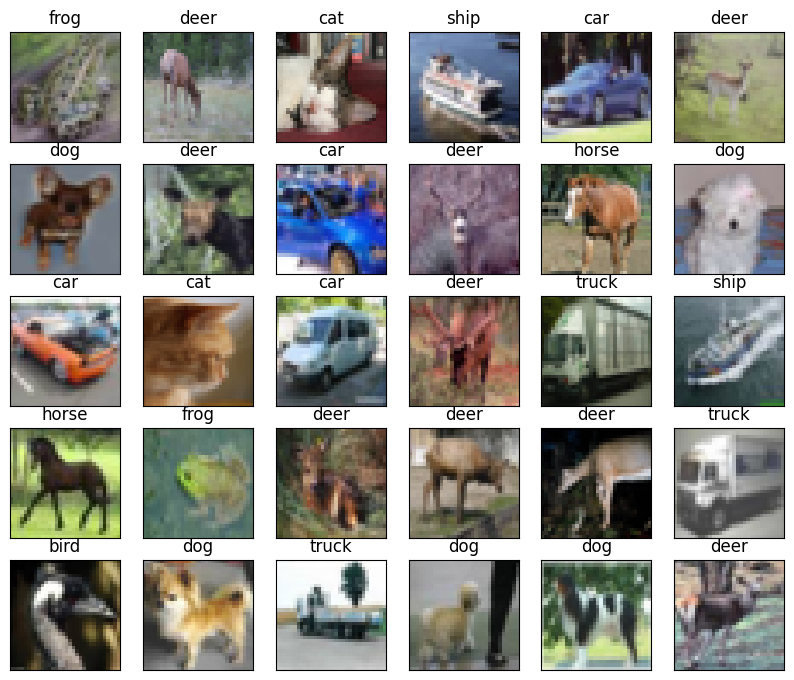

In [34]:
visualize_images()

In [35]:
@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

In [36]:
exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 16 #@param {type: "integer"}
epochs = 10 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config={
    'img_size':224,
    'patch_size':16,
    'in_channels':3,
    'emb_size':768,
    'num_heads':12,
    'mlp_size':3072,
    'dropout':0.1,
    'num_blocks':12,
    'num_classes':10
}

In [ ]:
class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images), labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassification(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()
